# Vehicle Detection
### by Kilian Muelken

---
#### Code Cell 1: necessary imports for the code

In [1]:
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.externals import joblib
import copy
from scipy.ndimage.measurements import label
from random import randint
from random import shuffle

___
## Part 1: Vehicle detection functions
*Functions for the vehicle Detection*

### Part 1.1: Common functions

___
#### Code Cell ?: Calculate sliding windows
**Input:** image, start and stop positions in both x and y, window size (x and y dimensions),  and overlap fraction (for both x and y)<br>
**Output:** List of sliding windows

In [2]:
def calcSlideWindows(img, xy_window, xy_overlap, x_start, x_stop, y_start, y_stop):
    #xy_window=(64, 64)
    #xy_overlap=(0.5, 0.5)
    #y_start = int(img.shape[0] * 0.5) # should be the highest place in the image, where cars can be seen
    #y_stop = img.shape[0] # above the bonnet
    #y_start = 400
    #y_stop = 656
        
    # Compute the span of the region to be searched    
    xspan = x_stop - x_start
    yspan = y_stop - y_start
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    slidingWindows = []
    
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start
            endy = starty + xy_window[1]
            
            # Append window position to list
            slidingWindows.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return slidingWindows

___
#### Code Cell ?: Plot and save images
**Input:** list of images<br>
**Output:** plots and saves images

In [3]:
def plotImage(imgs, save=False):
    # check if imgs is a list
    imglist = []
    
    if isinstance(imgs, list):
        imglist = imgs
    else:
        imglist.append(imgs)
        
    n_img = len(imglist)
    
    plt.figure(figsize=(20,5))
    
    for i in range(n_img):
        # plot image
        n_plot = 101 + n_img*10 + i
        plt.subplot(n_plot) # source: https://stackoverflow.com/questions/35692507/plot-several-image-files-in-matplotlib-subplots
        plt.imshow(imglist[i])
        
        # save image if save=true
        if save:
            #img_BGR = cv2.cvtColor(img_list[i],cv2.COLOR_RGB2BGR)
            img_name = 'image_'+time.strftime('%m_%Y_%H_%M_%S')+'.jpg'
            mpimg.imsave('output_images/'+img_name, imglist[i])

___
#### Code Cell ?: Draw bounding boxes
**Input:** image to draw the boxes, position and size of the boxes<br>
**Output:** image with boxes drawn

In [4]:
def drawBoxes(img, bboxes, color = (0, 0, 255), thick = 6):
    #color = (0, 0, 255) # Color of the boxes is blue
    #thick = 6  # thickness of the boxes
    
    img_boxes = np.copy(img) # Make a copy of the image
    
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(img_boxes, bbox[0], bbox[1], color, thick) # Draw a rectangle given bbox coordinates
    
    return img_boxes # return the image with boxes drawn

#### Code Cell ?: Read test images
**Input:** path of the test images<br>
**Output:** images with marked detected vehicles

In [5]:
def readImages(path):
    images = []
    images_list = glob.glob(path) # Make a list of calibration images

    # Step through the list, read test images and convert them to RGB
    for fname in images_list:
        img = cv2.imread(fname)
        rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        images.append(rgb)
    return images

___
#### Code Cell ?: Search for positive matches in windows
*Uses extractFeatures()*
**Input:** Image, Silde windows, Classifier, Scaler<br>
**Output:** positive matches in windows

In [6]:
def searchPositiveWindows(img, windows, clf, scaler):
    
    # Create an empty list to receive positive detection windows
    on_windows = []
    
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        # Extract features for that window using single_img_features()
        features = extractFeatures(test_img)
        
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        # Predict using your classifier
        prediction = clf.predict(test_features)
        
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    # Return windows for positive detections
    return on_windows

___
#### Code Cell ?: Check if windows are overlapping
**Input:** 2 Windows<br>
**Output:** Boolean (True if they are overlapping)

In [7]:
# check if windows overlap
def overlapWindow(win1, win2):
    x_left_w1 = win1[0][0] # x positition of the left upper point of the first window
    y_top_w1 = win1[0][1] # y positition of the left upper point of the first window
    x_right_w1 = win1[1][0] # x positition of the right bottom point of the first window
    y_bottom_w1 = win1[1][1] # y positition of the right bottom point of the first window
    
    x_left_w2 = win2[0][0] # x positition of the left upper point of the second window
    y_top_w2 = win2[0][1] # y positition of the left upper point of the second window
    x_right_w2 = win2[1][0] # x positition of the right bottom point of the second window
    y_bottom_w2 = win2[1][1] # y positition of the right bottom point of the second window
    
    # if left upper point of the first window is in the second window
    if ( (x_left_w2 <= x_left_w1 <= x_right_w2) & (y_top_w2 <= y_top_w1 <= y_bottom_w2) ):
        overlap = True
            
    # if right upper point of the first window is in second window
    elif ( (x_left_w2 <= x_right_w1 <= x_right_w2) & (y_top_w2 <= y_top_w1 <= y_bottom_w2) ):
        overlap = True
        
    # if left bottom point of the first window is in second window
    elif ( (x_left_w2 <= x_left_w1 <= x_right_w2) & (y_top_w2 <= y_bottom_w1 <= y_bottom_w2) ):
        overlap = True
        
    # if right bottom point of the first window is in second window
    elif ( (x_left_w2 <= x_right_w1 <= x_right_w2) & (y_top_w2 <= y_bottom_w1 <= y_bottom_w2) ):
        overlap = True
        
    # if there is no overlapping
    else:
        overlap = False
    
    return overlap

___
#### Code Cell ?: Find and eliminate false positive windows
**Input:** Detected windows with cars<br>
**Output:** Windows with eliminated false positives

In [8]:
def falsePositives(windows, last_windows):
    
    # Create an empty list to receive positive detection windows
    windows_eliminated = []
    
    # Iterate over all windows in the list
    for window in windows:        
        for last_window in last_windows:            
            if overlapWindow(window, last_window):
                windows_eliminated.append(window)
    
    return windows_eliminated

___
#### Code Cell ?: Find and merge mulitple detections
**Input:** Detected windows with cars<br>
**Output:** windows with merged multiple detections

In [9]:
def addHeat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # normalize heatmap
    max_heat = heatmap.max()
    if max_heat < 4:
        max_heat = 4
    heatmap /= max_heat
        
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


def getbboxes(labels):
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        bboxes.append(bbox)

    # Return the bboxes
    return bboxes


        
def multipleDetections(image, windows):
    threshold = 0.1
    
    new_heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # define a map to add the heat
    if ('heatmap' not in globals()):
        heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # add new heat to the map
    new_heatmap = addHeat(new_heatmap, windows)
        
    # calculate average with old heat
    heatmap = (new_heatmap + 3*heatmap) / 4.0
    
    print(heatmap.max())
    
    # reduce heat less than threshold
    heatmap[heatmap <= threshold] = 0
    
    # detect cars on image
    labels = label(heatmap)
    
    # get boxes around the detected cars
    windows_final = getbboxes(labels)
    
    # draw boxes on the image
    image_final = drawBoxes(image, windows_final)
    
    return image_final

___
### Part 1.2: Feature functions

___
#### Code Cell ?: Compute HOG features
**Input:** Image<br>
**Output:** HOG features

In [10]:
def hogFeatures(img):
    orientations = 9
    pix_per_cell = 8
    pixels_per_cell=(pix_per_cell, pix_per_cell)
    cell_per_block = 2
    cells_per_block=(cell_per_block, cell_per_block)
    visualise = False
    feature_vector = False # was True!!
    hog_channel = 'ALL'
    
    if hog_channel == 'ch':
        features = hog(img, orientations=orientations, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block), 
                    block_norm= 'L2-Hys',
                    transform_sqrt=True, 
                    visualise=visualise, feature_vector=feature_vector)
    elif hog_channel == 'ALL':
        features = []
        for channel in range(img.shape[2]):
            features_channel = hog(img[:,:,channel], orientations=orientations, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       visualise=visualise, feature_vector=feature_vector)
            features.append(features_channel)
        features = np.ravel(features)
    else:
        img_hog = img[:,:,hog_channel]
        features = hog(img_hog, orientations=orientations, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block), 
                    block_norm= 'L2-Hys',
                    transform_sqrt=True, 
                    visualise=visualise, feature_vector=feature_vector)
    return features

___
#### Code Cell ?: Compute binned color features 
**Input:** Image<br>
**Output:** binned color features

In [11]:
def binSpatial(img):
    size=(32, 32)
    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    
    # Return the feature vector
    return features

___
#### Code Cell ?: Compute color histogram features 
**Input:** Image<br>
**Output:** binned color features

In [12]:
def colorHist(img):
    nbins=32
    bins_range=(0, 256) # NEED TO CHANGE bins_range if reading .png files with mpimg!
        
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return features

___
#### Code Cell ?: Extract features 
*Uses hogFeatures(), binSpatial() and colorHist()*
**Input:** Image<br>
**Output:** features

In [13]:
def extractFeatures(imgs):
    color_space = 'YCrCb'
    spatial_feat = True
    hist_feat  =True
    hog_feat = True
    
    # check if imgs is a list
    if isinstance(imgs, list):
        imglist = imgs
    else:
        imglist = []
        imglist.append(imgs)
        
    # Create a list to append feature vectors to
    features = []
    
    for img in imglist:
        img_features = []
    
        # color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(img) 

        # Compute binned color features
        if spatial_feat == True:
            spatial_features = binSpatial(feature_image)
            img_features.append(spatial_features)
            

        # Compute color histogram features
        if hist_feat == True:
            hist_features = colorHist(feature_image)
            img_features.append(hist_features)
            

        # Compute HOG features
        if hog_feat == True:
            hog_features = hogFeatures(feature_image)
            img_features.append(hog_features)

        features.append(np.concatenate(img_features))
        
    # Return list of feature vectors
    return features

___
## Part ?: Training of the Classifier
*Training of the Classifier with test images*<br>

#### Code Cell ?: Training Pipeline
**Input:** path of the training images<br>
**Output:** trained classifier

In [14]:
def splitImages(images):
    images_split = []
    for image in images:
        i = randint(0, 15)
        if i == 0:
            img = cv2.resize(image[0:image.shape[0]*3//4 , 0:image.shape[1]*3//4 , :], (64,64))
            images_split.append(img)
        elif i == 1:
            img = cv2.resize(image[image.shape[0]//4:image.shape[0] , 0:image.shape[1]*3//4 , :], (64,64))
            images_split.append(img)
        elif i == 2:
            img = cv2.resize(image[0:image.shape[0]*3//4 , image.shape[1]//4:image.shape[1] , :], (64,64))
            images_split.append(img)
        elif i == 3:
            img = cv2.resize(image[image.shape[0]//4:image.shape[0] , image.shape[1]//4:image.shape[1] , :], (64,64))
            images_split.append(img)
        else:
            images_split.append(image)
    shuffle(images_split)
    return images_split
    

def trainingPipeline(cars, notcars):
    n_cars = len(cars)
    n_notcars = len(notcars)
    print(n_cars)
    print(n_notcars)
    
    if n_cars < n_notcars:
        notcars = notcars[0:n_cars]
    elif n_notcars < n_cars:
        cars = cars[0:n_notcars]
    
    car_features = extractFeatures(cars)
    notcar_features = extractFeatures(notcars)
        
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    # Use a linear SVC 
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    return svc, X_scaler

In [15]:
training = False # Set to True for new training

if training:
    # read train images
    notcars = readImages('train_nv/*.png')
    cars = readImages('train_v/*.png')
    
    notcars = splitImages(notcars)
    cars = splitImages(cars)

    clf, scaler = trainingPipeline(cars, notcars)

    # save the classifier and scaler to the disk
    # source: http://scikit-learn.org/stable/modules/model_persistence.html
    joblib.dump(clf, 'clf.pkl')
    joblib.dump(scaler, 'scaler.pkl')

In [16]:
# load the classifier and scaler
# source: http://scikit-learn.org/stable/modules/model_persistence.html
clf = joblib.load('clf.pkl')
scaler = joblib.load('scaler.pkl')

___
## Part ?: Testing
*Test of the Classifier with test images and test video*<br>

___
#### Code Cell ?: Image Testing Pipeline
*Test of the Classifier with test images*<br>
**Input:** path of the test images<br>
**Output:** images with marked detected vehicles

In [17]:
def pipeline(img):
    global heatmap # detected windows from the last image
    
    image = np.copy(img) # Make a copy of the image
    
    # calculate the searching windows
    slide_windows = calcSlideWindows(image, (32, 32), (0.5, 0.5), 320, 960, 400, 432)
    slide_windows.extend(calcSlideWindows(image, (64, 64), (0.5, 0.5), 128, 1152, 400, 464))
    slide_windows.extend(calcSlideWindows(image, (96, 96), (0.75, 0.75), 96, 1184, 400, 496))
    slide_windows.extend(calcSlideWindows(image, (128, 128), (0.75, 0.75), 64, 1216, 400, 528))
    slide_windows.extend(calcSlideWindows(image, (160, 160), (0.875, 0.875), 0, 1280, 400, 560))
    slide_windows.extend(calcSlideWindows(image, (192, 192), (0.875, 0.875), 16, 1264, 400, 592))
    slide_windows.extend(calcSlideWindows(image, (256, 256), (0.875, 0.875), 0, 1280, 400, 656))
    
    
    # find positive matches in searching windows
    car_windows = searchPositiveWindows(image, slide_windows, clf, scaler)

    # merge multiple detections
    image_cars = multipleDetections(image, car_windows)
        
    return image_cars

In [18]:
# test of slide images
def pipelineTest(img):
    image = np.copy(img) # Make a copy of the image
    
    # calculate the searching windows
    slide_windows32 = calcSlideWindows(image, (32, 32), (0.5, 0.5), 320, 960, 400, 432)
    #image = drawBoxes(image, slide_windows32, color = (255, 0, 0), thick = 2)
    
    # calculate the searching windows
    slide_windows64 = calcSlideWindows(image, (96, 96), (0.75, 0.75), 96, 1184, 400, 496)
    #image = drawBoxes(image, slide_windows64, color = (255, 0, 0), thick = 2)
    
    slide_windows92 = calcSlideWindows(image, (192, 192), (0.875, 0.75), 16, 1264, 400, 592)
    #image = drawBoxes(image, slide_windows92, color = (0, 255, 0), thick = 2)
    
    slide_windows128 = calcSlideWindows(image, (256, 256), (0.875, 0.875), 0, 1280, 400, 656)
    image = drawBoxes(image, slide_windows128, color = (0, 0, 255), thick = 2)
        
    return image

#images = []
#images.append(pipelineTest(test_images[4]))
#plotImage(images, True)

0.25
0.0625
0.125
0.25
0.25
0.25


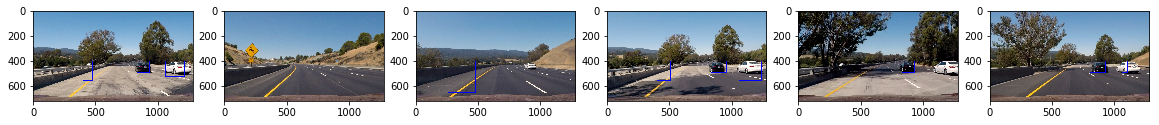

In [19]:
# read test images
test_images = readImages('test_images/*.jpg')

images = []

for test_image in test_images:
    # pipeline
    test_image_detected = pipeline(test_image)
    images.append(test_image_detected)
    
plotImage(images)

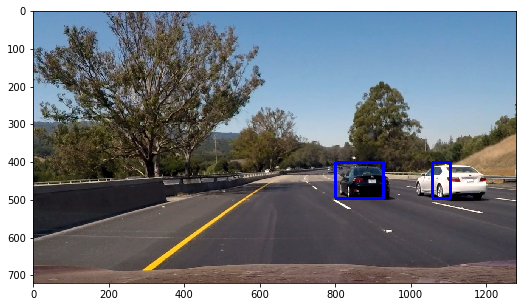

In [20]:
plotImage(images[5])

#### Code Cell ?: Detect vehicles on video
**Input:** name of the test video<br>
**Output:** video with marked detected vehicles will be written in current folder

In [21]:
def detectVehicles(video_file_name):
    #clip = VideoFileClip(video_file_name+'.mp4')
    clip = VideoFileClip(video_file_name+'.mp4').subclip(32,34)
    video_clip = clip.fl_image(pipeline)
    %time video_clip.write_videofile(video_file_name+'_with_detected_vehicles.mp4', audio=False)

In [22]:
detectVehicles('project_video')

0.25
[MoviePy] >>>> Building video project_video_with_detected_vehicles.mp4
[MoviePy] Writing video project_video_with_detected_vehicles.mp4


  0%|                                                                                           | 0/51 [00:00<?, ?it/s]

0.25


  2%|█▋                                                                                 | 1/51 [00:01<01:38,  1.98s/it]

0.25


  4%|███▎                                                                               | 2/51 [00:03<01:31,  1.86s/it]

0.25


  6%|████▉                                                                              | 3/51 [00:05<01:25,  1.77s/it]

0.25


  8%|██████▌                                                                            | 4/51 [00:06<01:16,  1.62s/it]

0.25


 10%|████████▏                                                                          | 5/51 [00:07<01:10,  1.54s/it]

0.25


 12%|█████████▊                                                                         | 6/51 [00:09<01:09,  1.55s/it]

0.25


 14%|███████████▍                                                                       | 7/51 [00:10<01:08,  1.55s/it]

0.25


 16%|█████████████                                                                      | 8/51 [00:12<01:08,  1.60s/it]

0.25


 18%|██████████████▋                                                                    | 9/51 [00:14<01:07,  1.61s/it]

0.25


 20%|████████████████                                                                  | 10/51 [00:15<01:03,  1.54s/it]

0.25


 22%|█████████████████▋                                                                | 11/51 [00:16<00:59,  1.50s/it]

0.25


 24%|███████████████████▎                                                              | 12/51 [00:18<00:58,  1.50s/it]

0.25


 25%|████████████████████▉                                                             | 13/51 [00:20<00:58,  1.55s/it]

0.25


 27%|██████████████████████▌                                                           | 14/51 [00:21<00:55,  1.51s/it]

0.25


 29%|████████████████████████                                                          | 15/51 [00:22<00:52,  1.46s/it]

0.25


 31%|█████████████████████████▋                                                        | 16/51 [00:24<00:52,  1.50s/it]

0.25


 33%|███████████████████████████▎                                                      | 17/51 [00:25<00:49,  1.46s/it]

0.25


 35%|████████████████████████████▉                                                     | 18/51 [00:27<00:46,  1.42s/it]

0.25


 37%|██████████████████████████████▌                                                   | 19/51 [00:28<00:44,  1.40s/it]

0.25


 39%|████████████████████████████████▏                                                 | 20/51 [00:30<00:44,  1.43s/it]

0.25


 41%|█████████████████████████████████▊                                                | 21/51 [00:31<00:40,  1.35s/it]

0.25


 43%|███████████████████████████████████▎                                              | 22/51 [00:32<00:40,  1.40s/it]

0.25


 45%|████████████████████████████████████▉                                             | 23/51 [00:34<00:39,  1.40s/it]

0.25


 47%|██████████████████████████████████████▌                                           | 24/51 [00:35<00:41,  1.53s/it]

0.25


 49%|████████████████████████████████████████▏                                         | 25/51 [00:37<00:36,  1.42s/it]

0.25


 51%|█████████████████████████████████████████▊                                        | 26/51 [00:38<00:37,  1.50s/it]

0.25


 53%|███████████████████████████████████████████▍                                      | 27/51 [00:40<00:35,  1.50s/it]

0.25


 55%|█████████████████████████████████████████████                                     | 28/51 [00:41<00:33,  1.45s/it]

0.25


 57%|██████████████████████████████████████████████▋                                   | 29/51 [00:43<00:34,  1.56s/it]

0.25


 59%|████████████████████████████████████████████████▏                                 | 30/51 [00:44<00:32,  1.54s/it]

0.25


 61%|█████████████████████████████████████████████████▊                                | 31/51 [00:46<00:28,  1.45s/it]

0.25


 63%|███████████████████████████████████████████████████▍                              | 32/51 [00:47<00:27,  1.43s/it]

0.25


 65%|█████████████████████████████████████████████████████                             | 33/51 [00:49<00:26,  1.50s/it]

0.25


 67%|██████████████████████████████████████████████████████▋                           | 34/51 [00:50<00:25,  1.49s/it]

0.25


 69%|████████████████████████████████████████████████████████▎                         | 35/51 [00:52<00:26,  1.63s/it]

0.25


 71%|█████████████████████████████████████████████████████████▉                        | 36/51 [00:54<00:25,  1.67s/it]

0.25


 73%|███████████████████████████████████████████████████████████▍                      | 37/51 [00:56<00:24,  1.73s/it]

0.25


 75%|█████████████████████████████████████████████████████████████                     | 38/51 [00:57<00:21,  1.68s/it]

0.25


 76%|██████████████████████████████████████████████████████████████▋                   | 39/51 [00:59<00:19,  1.63s/it]

0.25


 78%|████████████████████████████████████████████████████████████████▎                 | 40/51 [01:00<00:17,  1.59s/it]

0.25


 80%|█████████████████████████████████████████████████████████████████▉                | 41/51 [01:02<00:15,  1.56s/it]

0.25


 82%|███████████████████████████████████████████████████████████████████▌              | 42/51 [01:03<00:13,  1.53s/it]

0.25


 84%|█████████████████████████████████████████████████████████████████████▏            | 43/51 [01:05<00:11,  1.45s/it]

0.25


 86%|██████████████████████████████████████████████████████████████████████▋           | 44/51 [01:06<00:10,  1.56s/it]

0.25


 88%|████████████████████████████████████████████████████████████████████████▎         | 45/51 [01:08<00:09,  1.53s/it]

0.25


 90%|█████████████████████████████████████████████████████████████████████████▉        | 46/51 [01:09<00:07,  1.53s/it]

0.25


 92%|███████████████████████████████████████████████████████████████████████████▌      | 47/51 [01:11<00:06,  1.58s/it]

0.25


 94%|█████████████████████████████████████████████████████████████████████████████▏    | 48/51 [01:13<00:04,  1.56s/it]

0.25


 96%|██████████████████████████████████████████████████████████████████████████████▊   | 49/51 [01:14<00:03,  1.54s/it]

0.25


 98%|████████████████████████████████████████████████████████████████████████████████▍ | 50/51 [01:16<00:01,  1.63s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_with_detected_vehicles.mp4 

Wall time: 1min 17s


# Code actually not used

In [23]:
def multipleDetectionsOld(windows):
    
    #### 1. seperate all windows in different window groups and put overlapping windows in the same group
    window_groups = []
    
    print(windows)
    
    #### 1.1 allocate windows to window groups
    for window1o in windows: # take a window from the list
        window1 = copy.copy(window1o)
        firstmatch = True # is true for the first match
        
        # 1.1.1 check if the window overlaps with a window in the window groups
        for win_group in window_groups: # go through exisiting window groups
            for window2 in win_group: # go through windows in the window group
                if overlapWindow(window1, window2): # check if the first window overlaps with a window
                    
                    # copy window group and append current window
                    if firstmatch: 
                        window_group = copy.deepcopy(win_group) # copy this group
                        window_groups.remove(win_group) # remove the group from the lsit of window groups
                        window_group.append(window1) # append the window to the window group
                        windows.remove(window1o) # remove current window from window list, because it is in a window group
                        firstmatch = False
                        
                    # if there are more matches, merge both window groups
                    else:
                        for window3 in win_group:
                            if window3 not in window_group:
                                window_group.append(window3)
                        
                        if win_group in window_groups:
                            window_groups.remove(win_group) # remove the group from the lsit of window groups
        
        # 1.1.2 if there is no overlap with a window of a existing group          
        if firstmatch:
            window_group = [] # make a new group
            window_group.append(window1) # append current window to group
            windows.remove(window1o) # delete current window from window list, because it is in a window group
        
        # append window group to list of window groups
        window_groups.append(window_group)


    #### 2. calculate the total windows for each group ##################################################
    windows_multiDetect = []
    print(window_groups)
    for win_group in window_groups:
        xul = min(win[0][0] for win in win_group)
        yul = min(win[0][1] for win in win_group)
        xbr = max(win[1][0] for win in win_group)
        ybr = max(win[1][1] for win in win_group)
                
        total_window = ((xul, yul), (xbr, ybr))
        windows_multiDetect.append(total_window)
    
    return windows_multiDetect

In [24]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, svc, X_scaler):
    cell_per_block = 2
    pix_per_cell = 8
    ystart = 400
    ystop = 656
    orient=9
    
    draw_img = np.copy(img) # copy image
    img = img.astype(np.float32)/255 # normalize
    
    img_tosearch = img[ystart:ystop,:,:] # area for searching
    ctrans_tosearch = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb) # convert color
    
    # rescale image
    scale = 1.5
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # get channels
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = hogFeatures(ch1)
    hog2 = hogFeatures(ch2)
    hog3 = hogFeatures(ch3)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = binSpatial(subimg)
            hist_features = colorHist(subimg)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

In [25]:
# read test images
if False:
    test_images = readImages('test_images/*.jpg')

    images = []

    for test_image in test_images:
        # pipeline
        test_image_detected = find_cars(test_image, clf, scaler)
        images.append(test_image_detected)

    plotImage(images)